In [1]:
#%% Set-up

import brightway2 as bw
import seaborn as sb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import warnings

# TIME
import time
start_time=time.time()

# Set working directry
path = "."
os.chdir(path)

# Import local
from cge_klausen import parameters as cge_parameters
from ege_klausen import parameters as ege_parameters
from cge_model import GeothermalConventionalModel
# from cge_model_NoRounding import GeothermalConventionalModel as GeothermalConventionalModel_NoRounding
from ege_model import GeothermalEnhancedModel
# from ege_model_NoRounding import GeothermalEnhancedModel as GeothermalEnhancedModel_NoRounding
from s_models import simplified_cge_model, simplified_ege_model
from lookup_func import lookup_geothermal
from Stoc_MultiMethod_LCA import Stoc_MultiMethod_LCA

# Set project
bw.projects.set_current("Geothermal")

# Retrieve methods 
ILCD_CC = [method for method in bw.methods if "ILCD 2.0 2018 midpoint no LT" in str(method) and "climate change total" in str(method)]
ILCD_HH = [method for method in bw.methods if "ILCD 2.0 2018 midpoint no LT" in str(method) and "human health" in str(method)]
ILCD_EQ = [method for method in bw.methods if "ILCD 2.0 2018 midpoint no LT" in str(method) and "ecosystem quality" in str(method)]
ILCD_RE = [method for method in bw.methods if "ILCD 2.0 2018 midpoint no LT" in str(method) and "resources" in str(method)]
ILCD = ILCD_CC + ILCD_HH + ILCD_EQ + ILCD_RE

# Find demand
_, _, _, _, _, _, _, _, _, _, _, _, _, _, electricity_conv_prod, electricity_enh_prod = lookup_geothermal()

# Number of iterations
n_iter=10

# Load simplified models coefficients
use_Andrea = True

if use_Andrea:
    coeffs_=pd.read_excel(os.path.join(path, "Simplified models coefficients - analytical.xlsx"), sheet_name=["alpha", "beta", "chi", "delta"], index_col=0, dtype=object)
    alpha = coeffs_["alpha"].to_dict()
    beta = coeffs_["beta"].to_dict()
    chi = coeffs_["chi"].to_dict()
    delta = coeffs_["delta"].to_dict()
else:
    coeffs_=pd.read_excel(os.path.join(path, "Simplified models coefficients conventional - symbolic.xlsx"), sheet_name=["alpha", "beta"], index_col=0, dtype=object)
    alpha = coeffs_["alpha"].to_dict()
    beta = coeffs_["beta"].to_dict()
    coeffs_=pd.read_excel(os.path.join(path, "Simplified models coefficients enhanced - symbolic.xlsx"), sheet_name=["chi", "delta"], index_col=0, dtype=object)
    chi = coeffs_["chi"].to_dict()
    delta = coeffs_["delta"].to_dict()
    
# To ignore warnings from MC (Sparse Efficiency Warning)
warnings.filterwarnings("ignore")

In [2]:
bw.projects.current

'Geothermal'

# Conventional

In [3]:
from Stoc_MultiMethod_LCA_pygsa import *

In [4]:
n_iter = 100

In [5]:
# Reference model
cge_parameters.stochastic(iterations=n_iter)
cge_model = GeothermalConventionalModel(cge_parameters)
cge_parameters_sto=cge_model.run_ps(cge_parameters)

In [6]:
demand = {electricity_conv_prod: 1}
method = ILCD[0]

lca = bw.LCA(demand, method)
lca.lci()
lca.lcia()
lca.score

0.08167050574550841

In [7]:
%%time
ref_cge = run_mc(n_iter, cge_parameters_sto, lca, ILCD)

Wall time: 10min 19s


In [8]:
# Simplified model
s_cge = {}
for method in ILCD:
    s_cge[method]=simplified_cge_model(cge_parameters, method, alpha, beta)

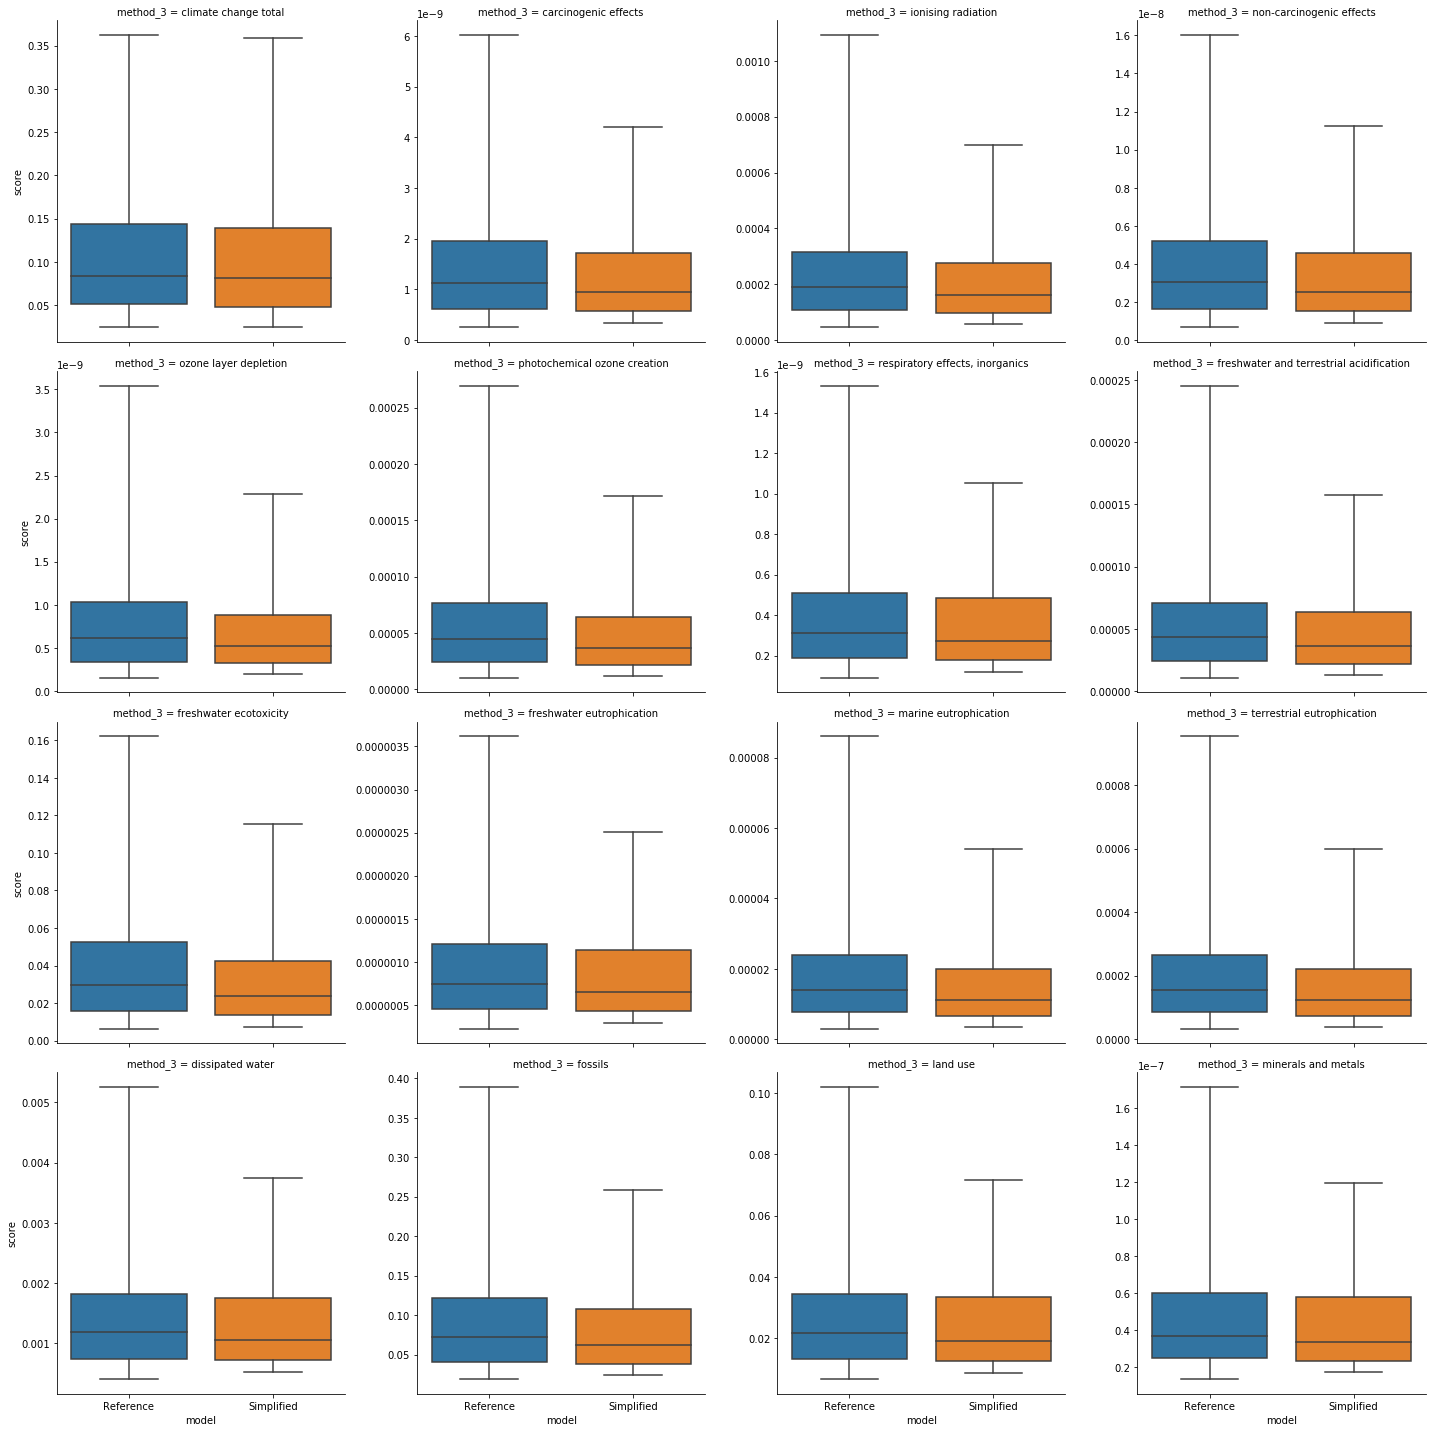

In [9]:
# Plot 2
#%% Conventional plot    
ref_cge_df=pd.DataFrame.from_dict(ref_cge, orient="columns").melt(var_name=["method_1", "method_2", "method_3"],value_name="Reference")
s_cge_df=pd.DataFrame.from_dict(s_cge, orient="columns").melt(var_name=["method_1", "method_2", "method_3"], value_name="Simplified")

cge_df = pd.merge(ref_cge_df, s_cge_df["Simplified"], how="left", left_index=True, right_index=True)
cge_df2=cge_df.melt(id_vars=["method_1", "method_2", "method_3"], var_name="model", value_name="score")

cge_plot = sb.catplot(data=cge_df2, x="model", y="score", col="method_3", kind="box", whis=[5,95], col_wrap=4, sharex=True, sharey=False, showfliers=False)


In [10]:
cge_plot.savefig('cge_plot.png')

## r squared

In [11]:
#%% Coefficient of determination and scatter plot

p=2 # Number of parameters in simplified models except conventional - CC
cge_r_squared, cge_adjusted_r_squared = {}, {}
for method in ILCD:
    df = cge_df[cge_df.method_3 == method[2]] 
    SS_Residual = sum(( df.Reference - df.Simplified ) **2 )
    SS_Total = sum(( df.Reference - df.Reference.mean() ) **2 ) 
    cge_r_squared[method] = 1 - (float(SS_Residual))/SS_Total
    if method != ILCD_CC[0]:
        cge_adjusted_r_squared[method] = 1 - (1-cge_r_squared[method])* (n_iter-1)/(p-1)

In [12]:
cge_r_squared

{('ILCD 2.0 2018 midpoint no LT',
  'climate change',
  'climate change total'): 0.9947901501629898,
 ('ILCD 2.0 2018 midpoint no LT',
  'human health',
  'carcinogenic effects'): 0.7742162773087374,
 ('ILCD 2.0 2018 midpoint no LT',
  'human health',
  'ionising radiation'): 0.7580106315547598,
 ('ILCD 2.0 2018 midpoint no LT',
  'human health',
  'non-carcinogenic effects'): 0.7756067472522843,
 ('ILCD 2.0 2018 midpoint no LT',
  'human health',
  'ozone layer depletion'): 0.7564142895494204,
 ('ILCD 2.0 2018 midpoint no LT',
  'human health',
  'photochemical ozone creation'): 0.749703481865648,
 ('ILCD 2.0 2018 midpoint no LT',
  'human health',
  'respiratory effects, inorganics'): 0.7778156373081875,
 ('ILCD 2.0 2018 midpoint no LT',
  'ecosystem quality',
  'freshwater and terrestrial acidification'): 0.7575231664481461,
 ('ILCD 2.0 2018 midpoint no LT',
  'ecosystem quality',
  'freshwater ecotoxicity'): 0.7728498470915554,
 ('ILCD 2.0 2018 midpoint no LT',
  'ecosystem quality

# Enhanced

In [13]:
demand = {electricity_enh_prod: 1}
method = ILCD[0]

lca = bw.LCA(demand, method)
lca.lci()
lca.lcia()
lca.score

0.0428841829296766

In [14]:
n_iter = 100

In [15]:
# Generate stochastic values
ege_parameters.stochastic(iterations=n_iter)

# Reference model
ege_model = GeothermalEnhancedModel(ege_parameters)
ege_parameters_sto=ege_model.run_ps(ege_parameters)
ref_ege = Stoc_MultiMethod_LCA(ege_parameters_sto, electricity_enh_prod, ILCD, n_iter)

In [16]:
%%time
ref_ege = run_mc(n_iter, ege_parameters_sto, lca, ILCD)

Wall time: 9min 44s


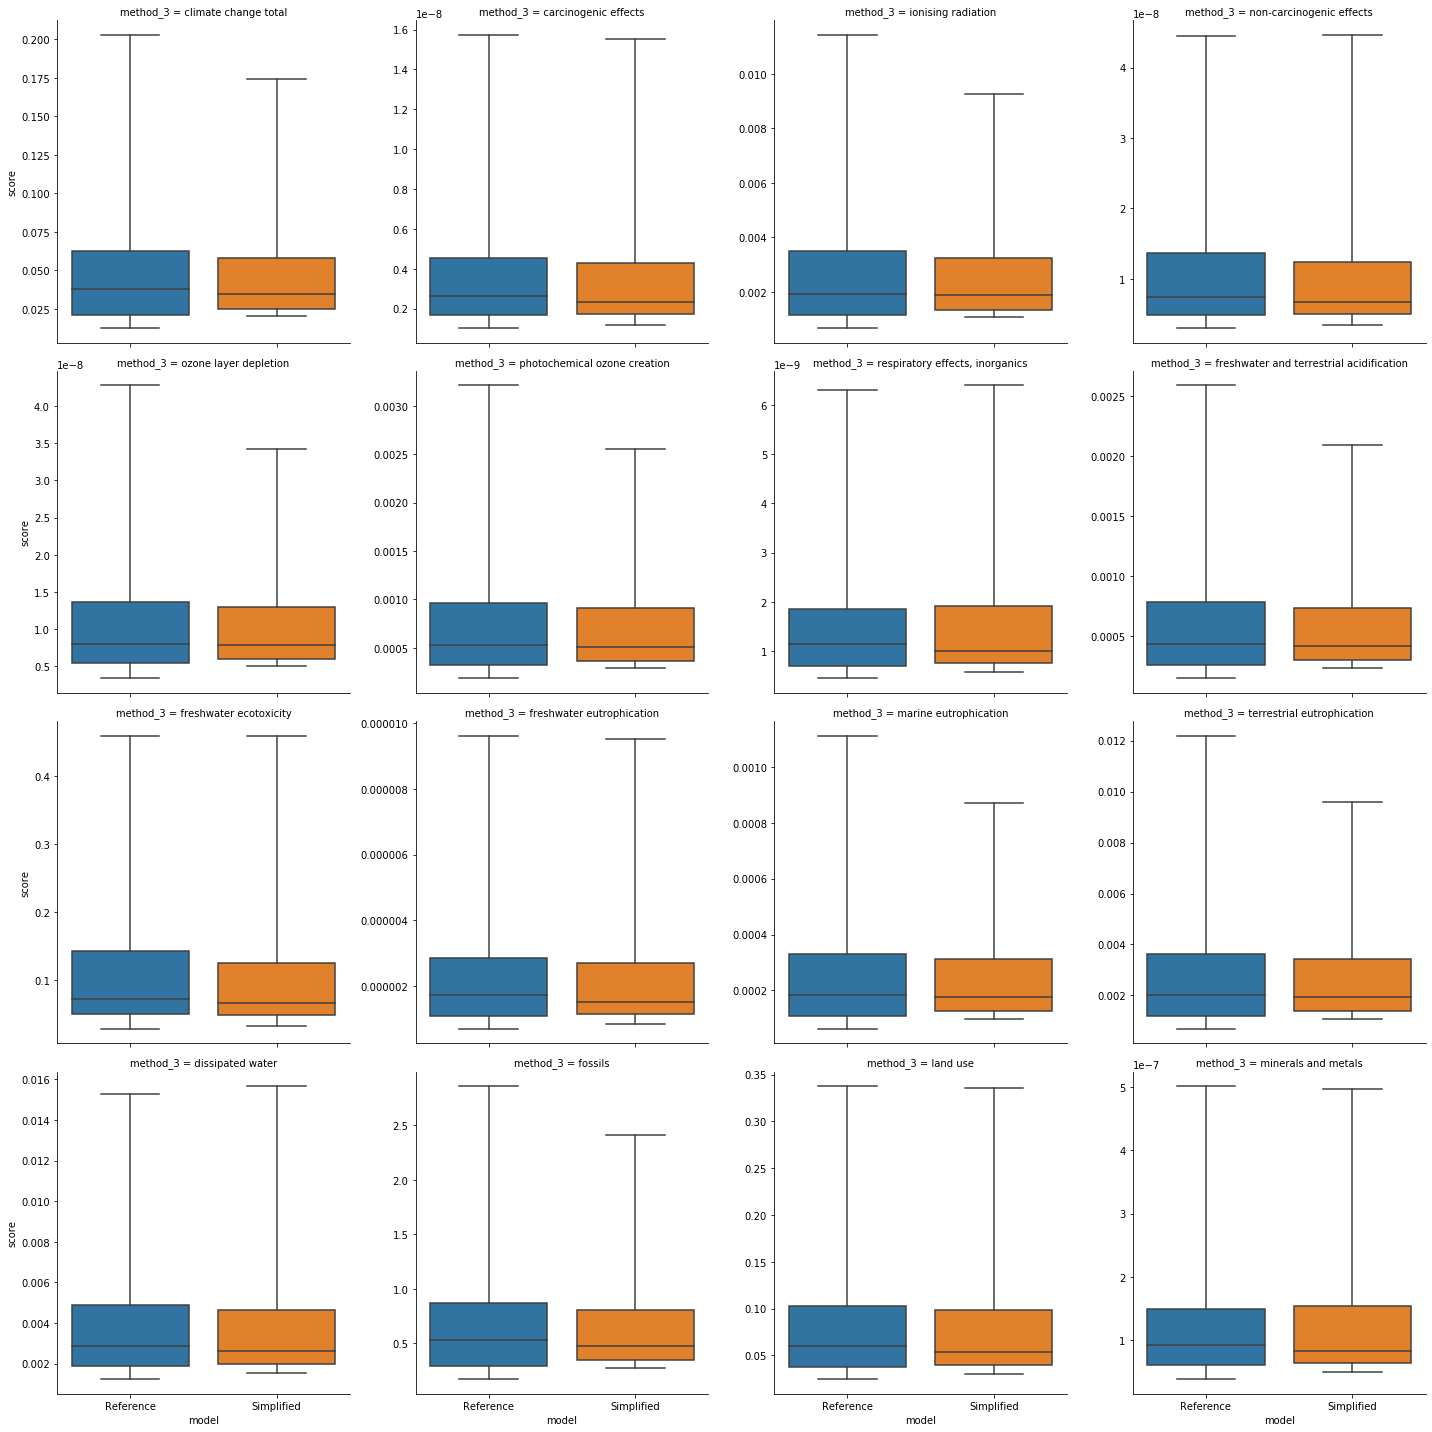

In [17]:
# Simplified model
s_ege={}
for method in ILCD:
    s_ege[method]=simplified_ege_model(ege_parameters, method, chi, delta)
    
#%% Plot enhanced

ref_ege_df=pd.DataFrame.from_dict(ref_ege, orient="columns").melt(var_name=["method_1", "method_2", "method_3"],value_name="Reference")
s_ege_df=pd.DataFrame.from_dict(s_ege, orient="columns").melt(var_name=["method_1", "method_2", "method_3"], value_name="Simplified")

ege_df = pd.merge(ref_ege_df, s_ege_df["Simplified"], how="left", left_index=True, right_index=True)
ege_df2=ege_df.melt(id_vars=["method_1", "method_2", "method_3"], var_name="model", value_name="score")

ege_plot = sb.catplot(data=ege_df2, x="model", y="score", col="method_3", kind="box", whis=[5,95], col_wrap=4, sharex=True, sharey=False, showfliers=False)


In [18]:
ege_plot.savefig('ege_plot.png')

In [19]:
#%% Coefficient of determination and scatter plot

p=2 # Number of parameters in simplified models except conventional - CC

ege_r_squared, ege_adjusted_r_squared = {}, {}
for method in ILCD:
    df = ege_df[ege_df.method_3 == method[2]] 
    SS_Residual = sum(( df.Reference - df.Simplified ) **2 )
    SS_Total = sum(( df.Reference - df.Reference.mean() ) **2 )
    ege_r_squared[method] = 1 - (float(SS_Residual))/SS_Total
    if method != ILCD_CC[0]:
        ege_adjusted_r_squared[method] = 1 - (1-ege_r_squared[method])* (n_iter-1)/(p-1)

end_time=time.time()

In [20]:
ege_r_squared

{('ILCD 2.0 2018 midpoint no LT',
  'climate change',
  'climate change total'): 0.8539046310367407,
 ('ILCD 2.0 2018 midpoint no LT',
  'human health',
  'carcinogenic effects'): 0.8142607397643862,
 ('ILCD 2.0 2018 midpoint no LT',
  'human health',
  'ionising radiation'): 0.8648543625189035,
 ('ILCD 2.0 2018 midpoint no LT',
  'human health',
  'non-carcinogenic effects'): 0.825789592015179,
 ('ILCD 2.0 2018 midpoint no LT',
  'human health',
  'ozone layer depletion'): 0.8650183941066872,
 ('ILCD 2.0 2018 midpoint no LT',
  'human health',
  'photochemical ozone creation'): 0.8664648947250824,
 ('ILCD 2.0 2018 midpoint no LT',
  'human health',
  'respiratory effects, inorganics'): 0.8376367826941952,
 ('ILCD 2.0 2018 midpoint no LT',
  'ecosystem quality',
  'freshwater and terrestrial acidification'): 0.8649989673470166,
 ('ILCD 2.0 2018 midpoint no LT',
  'ecosystem quality',
  'freshwater ecotoxicity'): 0.8328709930222433,
 ('ILCD 2.0 2018 midpoint no LT',
  'ecosystem quality